<a href="https://colab.research.google.com/github/emahkhujaemah/algoritma-ml/blob/main/skripsi_sentiment_analysis_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

This script performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is in turn used to predict the sentiments behind tweets fetched in real time using `tweepy` and classify them as positive negative or neutral.

The model is then integrated with streamlit and deployed as a web-app.

**Checkout the web-app:** [Sententia](https://share.streamlit.io/kritanjalijain/twitter_sentiment_analysis/main/app.py)

## Installing and importing dependencies

To fetch tweets from twitter, we need to install the tweepy library. We will be using this package to pull tweets on which our model will make predictions.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Exploratory Data Analysis

### Cleaning and prepping dataset

The `category` column has 3 values:
1. 0 Indicating it is a Neutral Sentiment
2. 1 Indicating a Postive Sentiment
3. -1 Indicating a Negative Sentiment

Skripsi


In [2]:
path = tf.keras.utils.get_file('sentimen-chatgpt-3class.csv',
                               'https://drive.google.com/uc?export=download&id=10HPxcinMuyfPlO84nLjmyKSj9DpTnsqv')
print(path)

35045516/35045516 [==============================] - 0s 0us/step
/root/.keras/datasets/sentimen-chatgpt-3class.csv


In [3]:
df = pd.read_csv(path)

df = df.drop(['Unnamed: 0'], axis=1)

df.head()

tweets   labels
0  ChatGPT: Optimizing Language Models for Dialog...  neutral
1  Try talking with ChatGPT, our new AI system wh...     good
2  ChatGPT: Optimizing Language Models for Dialog...  neutral
3  THRILLED to share that ChatGPT, our new model ...     good
4  As of 2 minutes ago, @OpenAI released their ne...      bad

In [4]:
# Extract out sentences and labels
sentences = df['tweets'].tolist()
labels = df['labels'].tolist()

In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'http[^ ]+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = re.sub(r'\b\w(1,2)\b', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r'([#])|([^a-zA-Z])', ' ', text)

    return text

df['clean_text'] = df['tweets'].apply(lambda x: clean_text(x))
df['category'] = df['labels'].map({'bad': -1.0, 'neutral': 0.0, 'good': 1.0})

clean_text("Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr")

'try talking with chatgpt our new ai system which is optimized for dialogue your feedback will help us improve it '

In [6]:
# Extract out sentences and labels
sentences = df['tweets'].tolist()
labels = df['labels'].tolist()
clean_text = df['clean_text'].tolist()
category = df['category'].tolist()

df.head()

tweets   labels  \
0  ChatGPT: Optimizing Language Models for Dialog...  neutral   
1  Try talking with ChatGPT, our new AI system wh...     good   
2  ChatGPT: Optimizing Language Models for Dialog...  neutral   
3  THRILLED to share that ChatGPT, our new model ...     good   
4  As of 2 minutes ago, @OpenAI released their ne...      bad   

                                          clean_text  category  
0   chatgpt optimizing language models for dialogue        0.0  
1  try talking with chatgpt our new ai system whi...       1.0  
2  chatgpt optimizing language models for dialogu...       0.0  
3  thrilled to share that chatgpt our new model o...       1.0  
4  as of minutes ago released their new chatgpt n...      -1.0

In [7]:
# Check for missing data
df.isnull().sum()

tweets        0
labels        0
clean_text    0
category      0
dtype: int64

In [8]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [9]:
#create a dataframe with all training data except the target column / drop column
df = df.drop(columns=['tweets', 'labels'])

In [10]:
# dimensionality of the data
df.shape

(219287, 2)

In [11]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

clean_text  category
0   chatgpt optimizing language models for dialogue    Neutral
1  try talking with chatgpt our new ai system whi...  Positive
2  chatgpt optimizing language models for dialogu...   Neutral
3  thrilled to share that chatgpt our new model o...  Positive
4  as of minutes ago released their new chatgpt n...  Negative

## Exploratory Data Analysis

Data Visualisation-

In [12]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [13]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

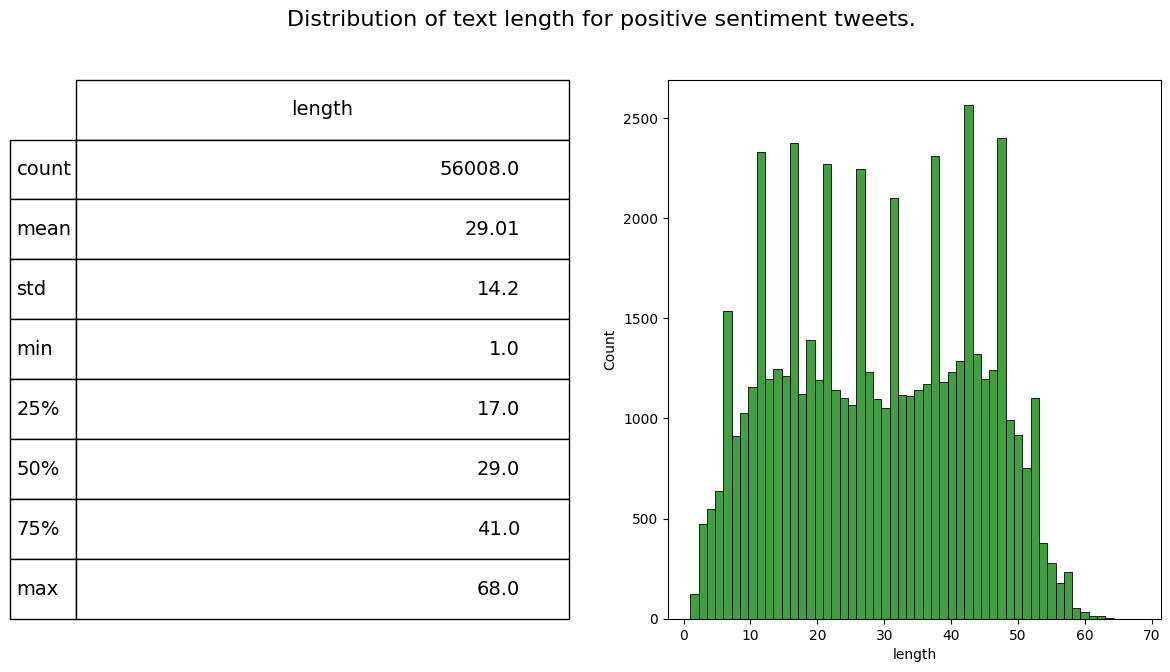

In [14]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

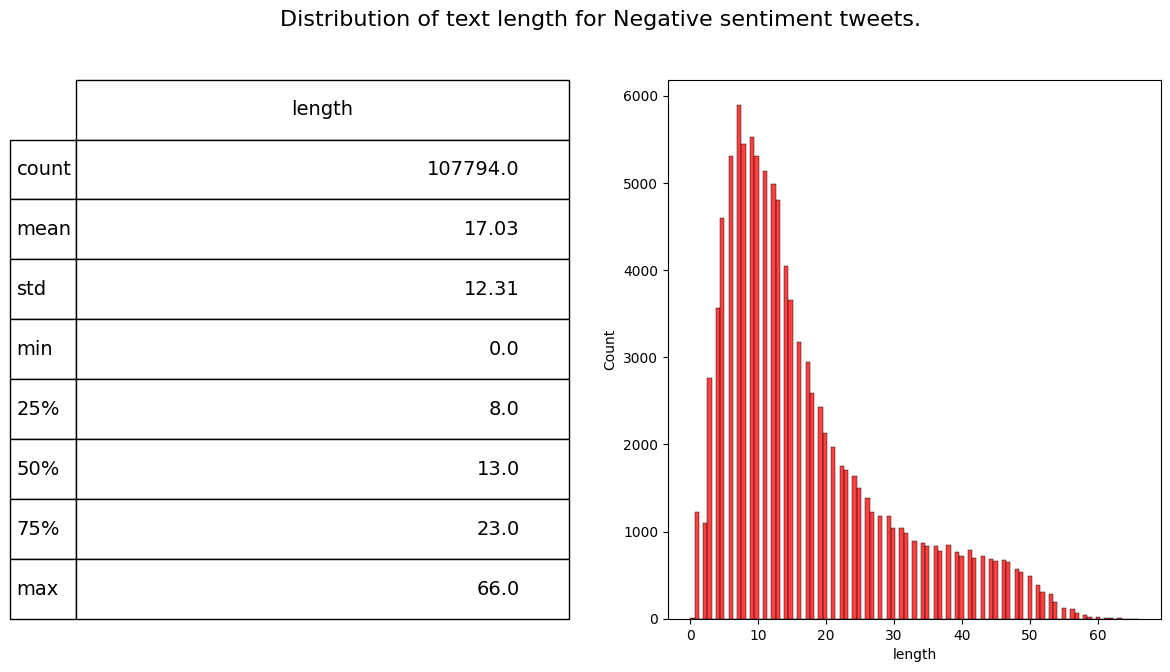

In [15]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [16]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [17]:
df.drop(['length'], axis=1, inplace=True)
# df.drop(['tweets'], axis=1, inplace=True)
# df.drop(['labels'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0        chatgpt optimizing language models for dialogue    Neutral
1       try talking with chatgpt our new ai system whi...  Positive
2       chatgpt optimizing language models for dialogu...   Neutral
3       thrilled to share that chatgpt our new model o...  Positive
4       as of minutes ago released their new chatgpt n...  Negative
...                                                   ...       ...
219282  other software projects are now trying to repl...  Negative
219283  i asked chatgpt to write a nye joke for seos a...  Positive
219284  chatgpt is being disassembled until it can onl...  Negative
219285   predictions by chatgpt nothing really specifi...  Negative
219286                           from chatgpt neat stuff    Neutral

[219287 rows x 2 columns]>

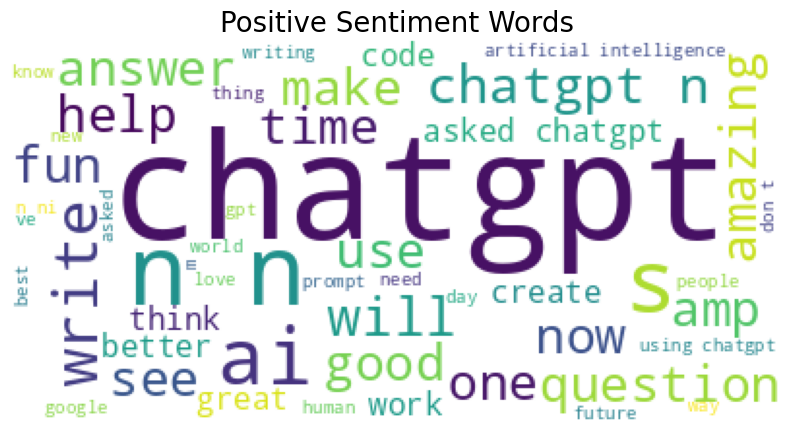

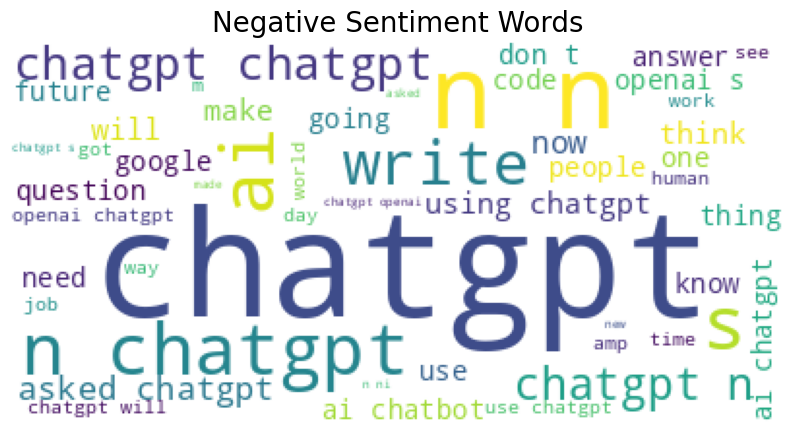

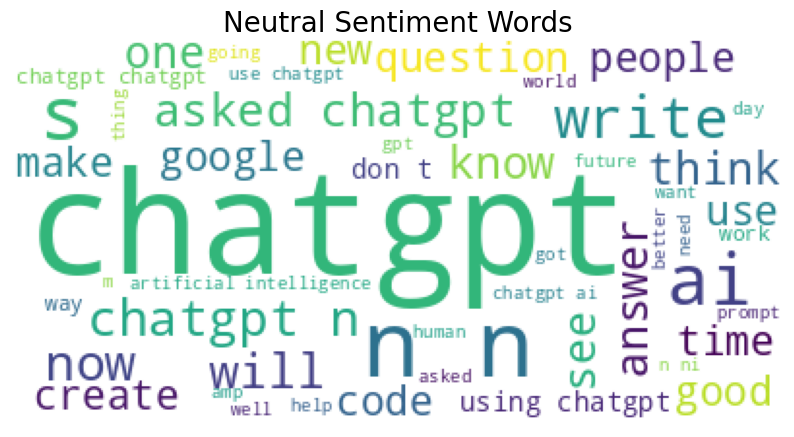

In [18]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')



## Data Preprocessing

In [19]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> chatgpt optimizing language models for dialogue 

Processed tweet -> ['chatgpt', 'optim', 'languag', 'model', 'dialogu']


In [20]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [22]:
print(X[0])
print(Y[0])

['chatgpt', 'optim', 'languag', 'model', 'dialogu']
1


### Train and test split

In [23]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [25]:
#import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
#X_train = pr.normalize(X_train, axis=1)
#X_test  = pr.normalize(X_test, axis=1)

In [26]:
# print first 200 words/tokens
# print(count_vector.get_feature_names()[0:200])

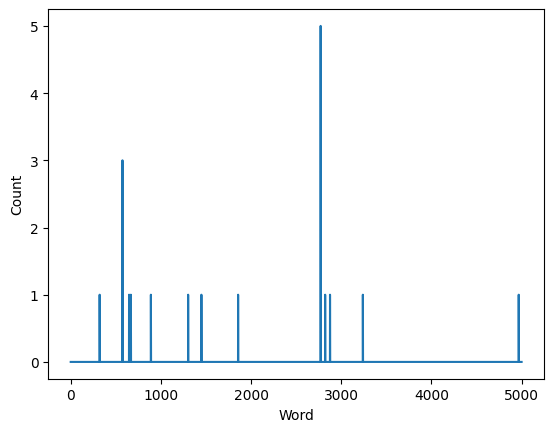

In [27]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)

    word_index = tokenizer.word_index

    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

# print(word_index)

Before Tokenization & Padding 
 chatgpt optimizing language models for dialogue 
After Tokenization & Padding 
 [   1 1423  108  245   12  654    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Saving tokenized data

In [29]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [30]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (131571, 50) (131571, 3)
Validation Set -> (43858, 50) (43858, 3)
Test Set -> (43858, 50) (43858, 3)


In [31]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 16
epochs=15
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.8

# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size)),
    tf.keras.layers.Dense(3, activation='softmax')
])

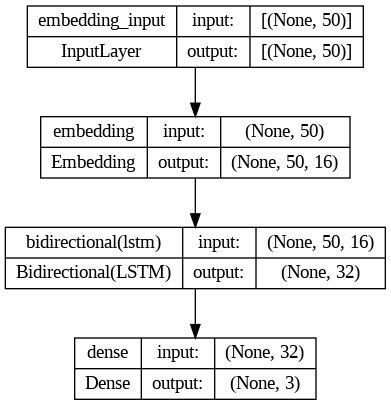

In [33]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            80000     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 84,323
Trainable params: 84,323
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
2056/2056 [==============================] - 71s 30ms/step - loss: 0.5186 - accuracy: 0.7957 - precision: 0.8351 - recall: 0.7494 - val_loss: 0.4000 - val_accuracy: 0.8605 - val_precision: 0.8689 - val_recall: 0.8508
Epoch 2/15
2056/2

### Model Accuracy & Loss

In [36]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8815
Precision : 0.8858
Recall    : 0.8779
F1 Score  : 0.8818


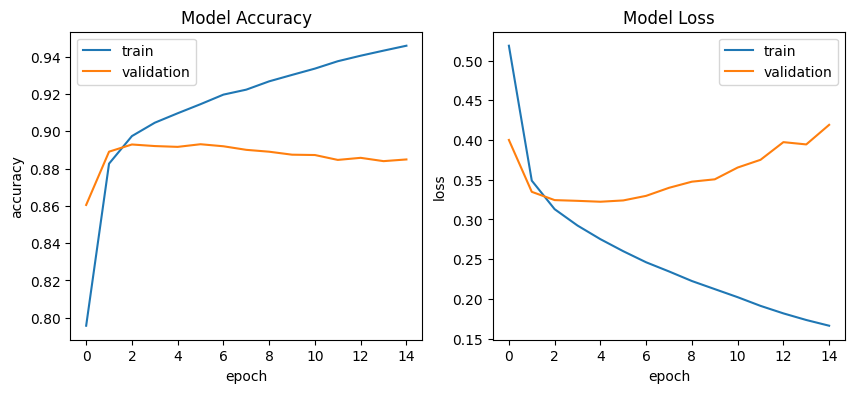

In [37]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### Model Confusion Matrix

1371/1371 [==============================] - 8s 5ms/step


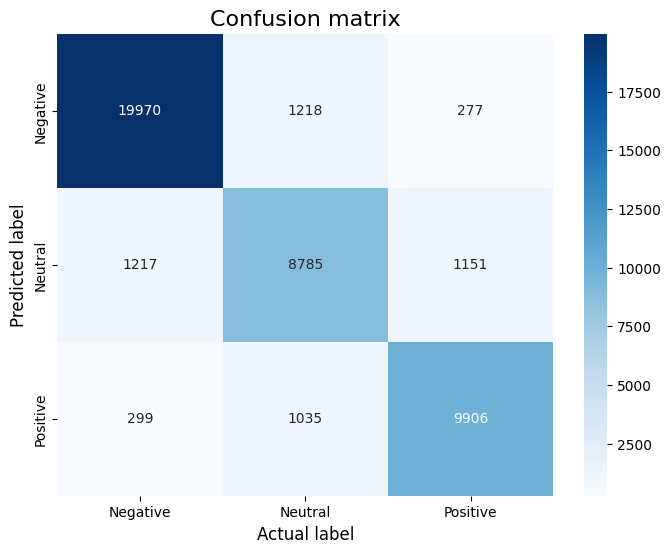

In [38]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [39]:
import pickle

pkl_filename = "lstm_model.pkl"
with open(pkl_filename, 'wb') as file:
  pickle.dump(pkl_filename, file)
  file.close()

In [40]:
# Save the model architecture & the weights
model.save('lstm_model.h5')
print('Best model saved')

Best model saved


In [41]:
from keras.models import load_model

# Load model
model = load_model('lstm_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)

    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [42]:
predict_class(['My latest video is out! How to train ChatGPT for Midjourney AI Art with some basic formulas'])

1/1 [==============================] - 1s 620ms/step
The predicted sentiment is Negative


In [43]:
predict_class(['ceo robin li on friday said the company will soon roll out ernie the new version of its ai powered chatgpt like chatbot large language models will be deeply integrated into the real economy in the future li said when attending the zgc forum in beijing'])

1/1 [==============================] - 0s 21ms/step
The predicted sentiment is Positive


In [44]:
predict_class(['heard of chatgpt you re in good company of us adults have got the memo but hey to the who ve tried it you re officially part of the cool club chatgpt jointhechatgptparty'])

1/1 [==============================] - 0s 21ms/step
The predicted sentiment is Positive


In [45]:
def predict_review(model, text):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(text)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_len)

  classes = model.predict(reviews_padded)
# for x in range(len(reviews_padded)):
  print(text[0])
  print(classes[0])
  print('\n')

# predict_review(model, new_reviews)

In [46]:
review = """my latest video is out how to train chatgpt for midjourney ai art with some basic formulas"""

predict_review(model, review)

3/3 [==============================] - 0s 4ms/step
m
[9.9602866e-01 3.3494825e-03 6.2177499e-04]




In [47]:
# Model CNN

vocab_size = 5000
embedding_size = 32
epochs=15
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.8

num_epochs = 15

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_len),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

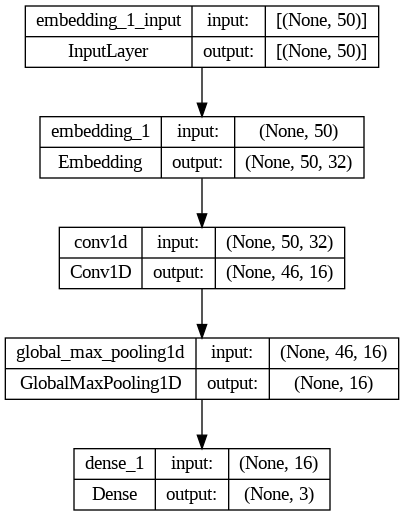

In [48]:
import tensorflow as tf
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [49]:
print(model_cnn.summary())

# Compile model_cnn
model_cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy', Precision(), Recall()])

# Train model_cnn

batch_size = 64
history = model_cnn.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            2576      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 162,627
Trainable params: 162,627
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
2056/2056 [==============================] - 69s 31ms/step - loss: 0.5507 - accuracy: 0.7771 - pre

### Model Accuracy & Loss

In [50]:
# Evaluate model_cnn on the test set
loss, accuracy, precision, recall = model_cnn.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8216
Precision : 0.8240
Recall    : 0.8195
F1 Score  : 0.8217


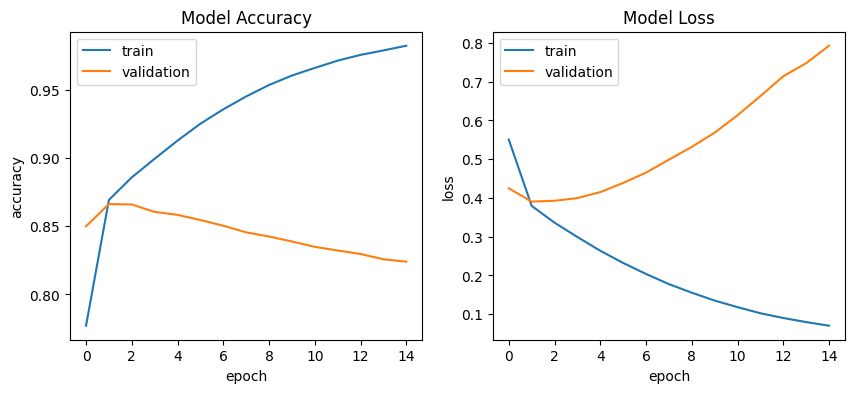

In [51]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### Model Confusion Matrix

1371/1371 [==============================] - 2s 2ms/step


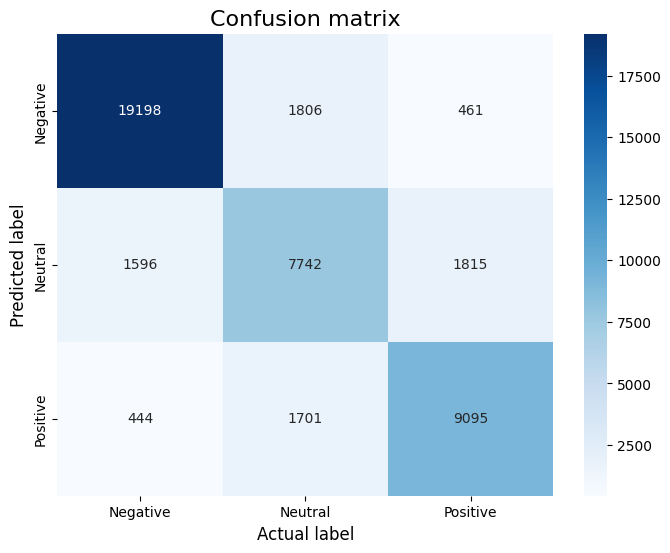

In [52]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model_cnn, X_test, y_test):
    '''Function to plot confusion matrix for the passed model_cnn and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model_cnn to do the prediction
    y_pred = model_cnn.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model_cnn, X_test, y_test)

### Model save and load for the prediction

In [53]:
import pickle

pkl_filename = "cnn_model.pkl"
with open(pkl_filename, 'wb') as file:
  pickle.dump(pkl_filename, file)
  file.close()

In [54]:
# Save the model architecture & the weights
model.save('cnn_model.h5')
print('Best model saved')

Best model saved
